In [1]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [2]:
pip uninstall bitsandbytes

Found existing installation: bitsandbytes 0.45.1
Uninstalling bitsandbytes-0.45.1:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/bitsandbytes-0.45.1.dist-info/*
    /usr/local/lib/python3.11/dist-packages/bitsandbytes/*
Proceed (Y/n)? Y
  Successfully uninstalled bitsandbytes-0.45.1


In [3]:
pip install -U bitsandbytes

  Using cached bitsandbytes-0.45.1-py3-none-manylinux_2_24_x86_64.whl.metadata (5.8 kB)
Using cached bitsandbytes-0.45.1-py3-none-manylinux_2_24_x86_64.whl (69.7 MB)


In [4]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import torch
import numpy as np
from transformers import AutoProcessor
from peft import PeftModel
from unsloth import FastVisionModel
from PIL import Image
import gradio as gr

## Load the fine-tuned model and tokenizer with LoRA adapter
base_model_name = "unsloth/Llama-3.2-11B-Vision-Instruct"
fine_tuned_model_name = "Murasajo/Llama-3.2-VL-Finetuned-on-HandwrittenText"

# Load base model with 4-bit to save memory
base_model, tokenizer = FastVisionModel.from_pretrained(
    base_model_name,
    load_in_4bit=True,  # Efficient for small GPUs
    use_gradient_checkpointing="unsloth",
)



In [ ]:
# Load LoRA adapter
model = PeftModel.from_pretrained(base_model, fine_tuned_model_name)

# Load processor for image handling
processor = AutoProcessor.from_pretrained(fine_tuned_model_name)

# Model in evaluation mode
model.eval()

print("✅ Model and processor loaded successfully!")




In [9]:
import requests
from PIL import Image
from io import BytesIO
# Example URL (replace with your image URL)
url = "https://i.pinimg.com/originals/ab/92/e0/ab92e0bc80aaa280f73bef31d099bf39.jpg"

# Fetch the image from the URL
response = requests.get(url)
if response.status_code == 200:
    # Open the image using Pillow
    image = Image.open(BytesIO(response.content))
    # Display the image
    image.show()
else:
    print("Failed to fetch the image. Status code:", response.status_code)


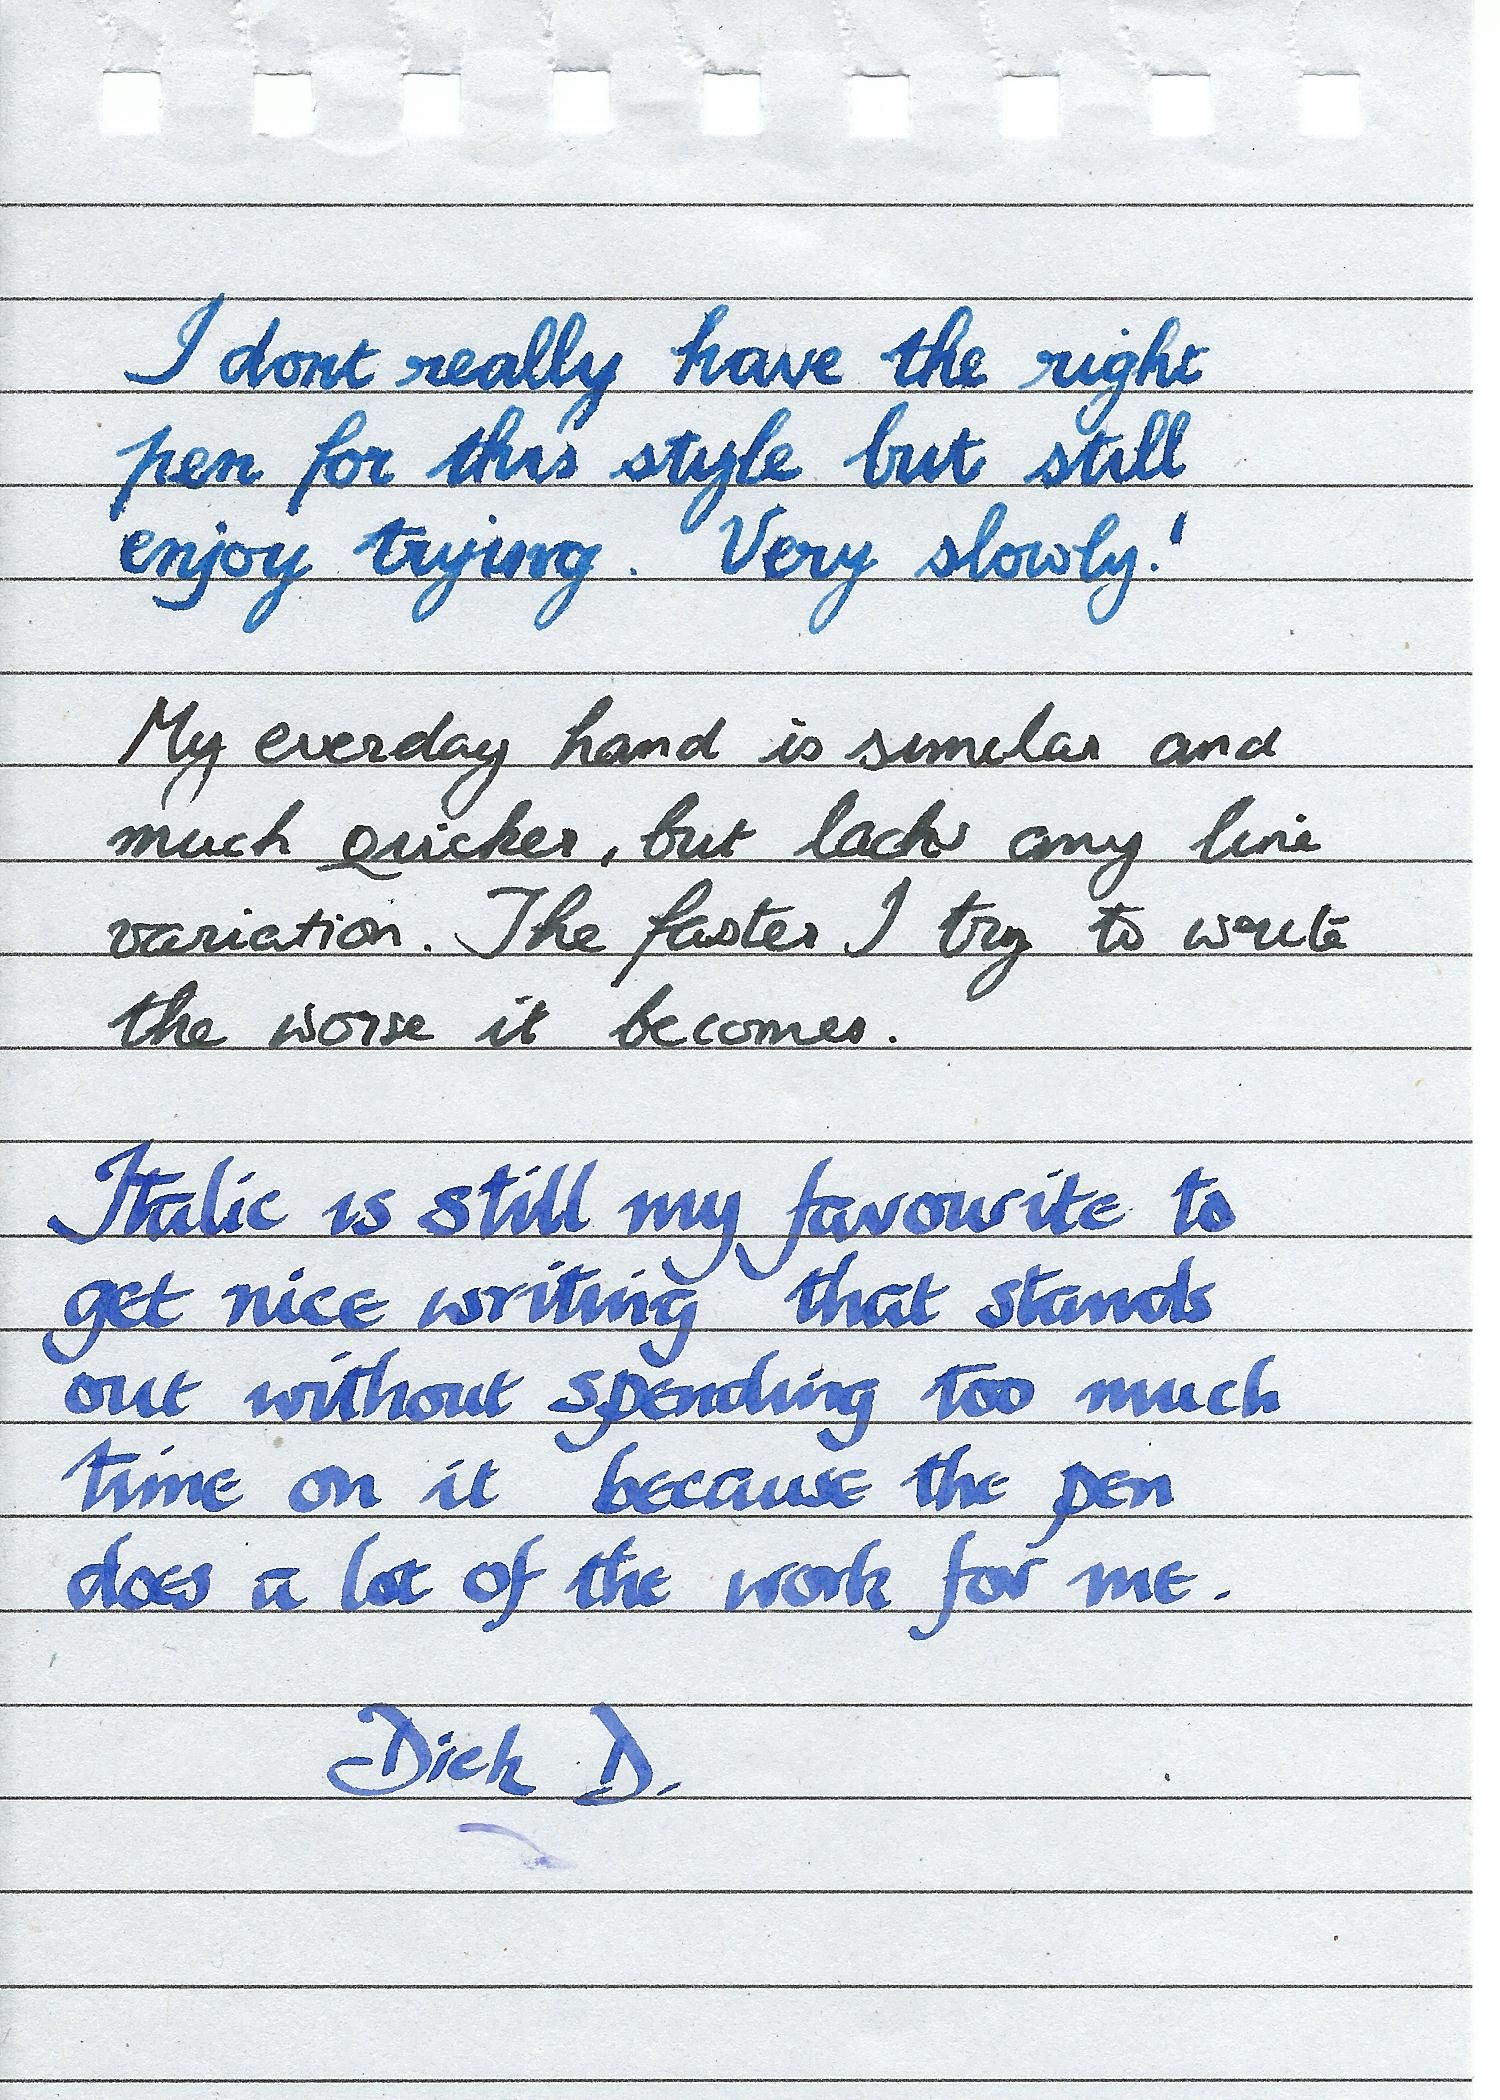

In [10]:
from IPython.display import display

# Display the image in the notebook
display(image)

In [11]:
from transformers import TextStreamer

FastVisionModel.for_inference(model)

prompt = "Extract all the handwritten text in the image, ensure precision and clarity. The text is handwritten and in English. Display it in a paragraph form as it is written in the image."

messages = [
    {"role": "user",
     "content":[
         {"type": "image"},
         {"type": "text", "text": prompt}
     ]}
]

input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
inputs = tokenizer(
    image,
    input_text,
    return_tensors="pt",
    add_special_tokens=False,
).to("cuda")

text_streamer = TextStreamer(tokenizer, skip_prompt=True)

_ = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=128,
    use_cache=True,
    temperature=1.5,
    min_p=0.1
)


I don't really have the right pen for this style but still enjoy trying. Very slowly. 

My everyday hand is similar and much quicker, but lacks any line variation. The faster I try to write the worse it becomes.

Italic is still my favourite to get nice writing that stands out without spending too much time on it because the pen does a lot of the work for me. 

Dick D.<|eot_id|>


In [16]:
import gradio as gr
import torch
from transformers import TextStreamer

def process_image(image, prompt):
    if image is None:
        return "Please upload an image first."

    try:
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": image},
                    {"type": "text", "text": prompt}
                ]
            }
        ]

        input_text = processor.apply_chat_template(messages, add_generation_prompt=True)

        inputs = processor(
            images=image,
            text=input_text,
            return_tensors="pt",
            add_special_tokens=False
        ).to("cuda" if torch.cuda.is_available() else "cpu")

        text_streamer = TextStreamer(processor, skip_prompt=True)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                streamer=text_streamer,
                max_new_tokens=128,
                use_cache=True,
                temperature=1.5,
                min_p=0.1
            )

        return processor.decode(outputs[0], skip_special_tokens=True)

    except Exception as e:
        return f"Error processing image: {str(e)}"

def extract_text(image, prompt):
    if not prompt.strip():
        prompt = "Extract all the handwritten text in the image, ensure precision and clarity. The text is handwritten and in English. Display it in a paragraph form as it is written in the image."

    return process_image(image, prompt)

# Create the Gradio interface
with gr.Blocks() as iface:
    gr.Markdown("# Handwritten Text Recognition System")

    with gr.Row():
        with gr.Column():
            # Input components
            image_input = gr.Image(type="pil", label="Upload Handwritten Text Image")
            prompt_input = gr.Textbox(
                label="Custom Prompt (optional)",
                placeholder="Enter your prompt here or leave empty for default prompt",
                lines=2
            )
            submit_btn = gr.Button("Extract Text")

        with gr.Column():
            # Output component - simple textbox instead of chat history
            text_output = gr.Textbox(
                label="Extracted Text",
                lines=10,
                interactive=False
            )

    # Event handler
    submit_btn.click(
        fn=extract_text,
        inputs=[image_input, prompt_input],
        outputs=[text_output]
    )

    gr.Markdown("""
    ## Instructions:
    1. Upload an image containing handwritten text
    2. (Optional) Customize the prompt for specific requirements
    3. Click 'Extract Text' to get the results
    4. The extracted text will appear in the output box
    """)

# Launch the interface
iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f1e3abc879eede8ff5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
